# Covid in NJ

In [1]:
import cmocean.cm as cmo
import folium
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Video
from matplotlib.colors import rgb2hex
from pyinla.model import *
from pyinla.raster import *
from pyinla.spde import *
from pyinla.utils import *
from tqdm.auto import tqdm

In [45]:
df = pd.read_csv("./data/jersey_covid_2021-2022.csv")
df = df[df.date.apply(lambda x: "2021" in x).values]
population = pd.read_csv("./data/njpop.csv")
income = pd.read_csv("./data/njincome.csv")
pov = pd.read_csv("./data/njpoverty.csv")

In [46]:
geojson = gpd.read_file("./data/nj_county_boundaries.geojson")
geojson = geojson[["geometry", "COUNTY", "FIPSSTCO"]]
geojson["fips"] = geojson["FIPSSTCO"].astype(int)
geojson = geojson.drop("FIPSSTCO", axis=1)
gdf = (
    geojson.merge(population, on="COUNTY")
    .merge(income, on="COUNTY")
    .merge(pov, on=["COUNTY", "fips"])
    .merge(df, on="fips")
)

In [47]:
gdf["death_frac"] = gdf.deaths / gdf.cases

<AxesSubplot: >

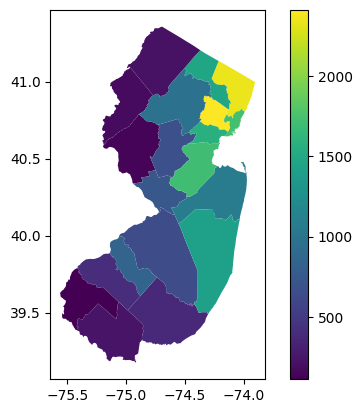

In [5]:
gdf[gdf.date == "2021-01-05"].plot("deaths", legend=True)

In [48]:
for i in range(1, len(gdf)):
    diff = gdf["cases"][i] - gdf["cases"][i - 1]
    if diff < 0:
        gdf.loc[i:, "cases"] = gdf.loc[i:, "cases"] + np.abs(diff)
    diff = gdf["deaths"][i] - gdf["deaths"][i - 1]
    if diff < 0:
        gdf.loc[i:, "deaths"] = gdf.loc[i:, "deaths"] + np.abs(diff)

In [49]:
d = gdf.date[0]

In [155]:
for i, d in tqdm(enumerate(np.unique(gdf.date))):
    ax = gdf[gdf.date == d].plot(
        "death_frac",
        cmap=cmo.deep,
        legend=1,
        vmin=0.0,
        vmax=0.06,
        norm=plt.Normalize(vmin=0.0, vmax=0.06),
    )
    ax.axis("off")
    ax.set_title(d)
    fig = ax.get_figure()
    fig.savefig(f"./out/njdf-{str(i).zfill(3)}.jpg", dpi=300)
    plt.close()

0it [00:00, ?it/s]

In [ ]:
!ffmpeg -framerate 30 -pattern_type glob -i '*.jpg' -c:v libx264 -pix_fmt yuv420p out.mp4

In [360]:
Video("./out/out.mp4", width=500, height=600)

In [50]:
counties = np.unique(gdf.COUNTY)
adj = np.zeros((counties.size, counties.size))
for i in range(len(counties)):
    for j in range(i, len(counties)):
        if (
            gdf[gdf.COUNTY == counties[i]]
            .iloc[0]
            .geometry.touches(gdf[gdf.COUNTY == counties[j]].iloc[0].geometry)
        ):
            adj[i, j] = 1
            adj[j, i] = 1

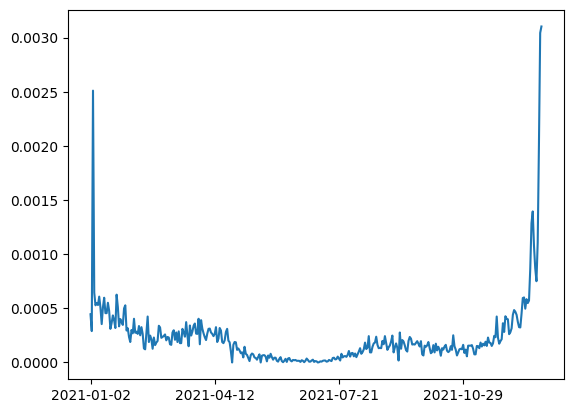

In [53]:
plt.plot(
    gdf[gdf.COUNTY == "MERCER"].date.iloc[1:],
    np.diff(gdf[gdf.COUNTY == "MERCER"].cases)
    / gdf[gdf.COUNTY == "MERCER"].pop2020.iloc[1:],
)
plt.xticks(plt.xticks()[0][::100]);

In [ ]:
county_id = (ro.r("as.factor")(gdf.COUNTY)).astype(float)
county_id_2 = county_id
time_id = (ro.r("as.factor")(gdf.date)).astype(float)

In [ ]:
g = rinla.inla_read_graph(adj)

In [288]:
formula = """
cases ~ f(county_id, model='bym', graph=g) + 
    f(county_id_2, time_id, model='iid') + 
    time_id + 
    poverty + 
    income
"""

In [357]:
res = inla(
    formula=formula,
    family="poisson",
    data=dict(
        cases=np.concatenate(
            gdf.groupby("COUNTY")
            .cases.apply(np.diff)
            .apply(lambda x: np.concatenate(([0], x)))
            .values
        ),
        county_id=county_id,
        county_id_2=county_id_2,
        time_id=time_id,
        poverty=gdf.poverty2021 / gdf.pop2021,
        income=gdf.income2021 / 1_000,
        g=g,
    ),
    E=gdf.pop2021,
    control_predictor=dict(compute=True),
).improve_hyperpar()

In [358]:
res

Time used:
     = 2.23,  = 0.452,  = 0.0374,  = 2.72 
Fixed effects:
               mean    sd 0.025quant 0.5quant 0.975quant    mode kld
(Intercept) -11.736 1.214    -14.130  -11.739     -9.323 -11.745   0
time_id       0.000 0.001     -0.001    0.000      0.001   0.000   0
poverty      12.655 5.123      2.470   12.671     22.750  12.698   0
income        0.032 0.011      0.011    0.032      0.054   0.032   0

Random effects:
  Name	  Model
    county_id BYM model
   county_id_2 IID model

Model hyperparameters:
                                                 mean       sd 0.025quant
Precision for county_id (iid component)       1856.07  1832.18   1.23e+02
Precision for county_id (spatial component)      1.10     0.35   5.49e-01
Precision for county_id_2                   191778.63 57888.05   9.88e+04
                                            0.5quant 0.975quant     mode
Precision for county_id (iid component)     1.30e+03   6.74e+03 3.37e+02
Precision for county_id (spatial compon

<AxesSubplot: >

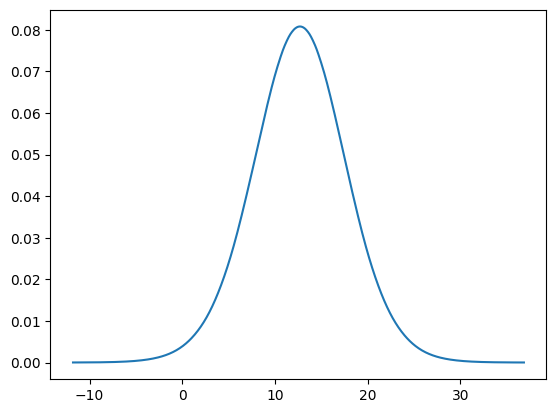

In [378]:
res.get_marginal_type("fixed").get_marginal("poverty").spline().plot()

In [360]:
rr_mode = res.get_summary("fitted.values")["mode"]

<AxesSubplot: >

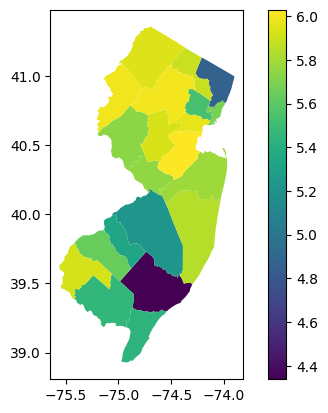

In [323]:
gdf[::365].plot(
    np.log10(rr_mode[::365] * gdf.pop2021[::365]),
    legend=1,
)

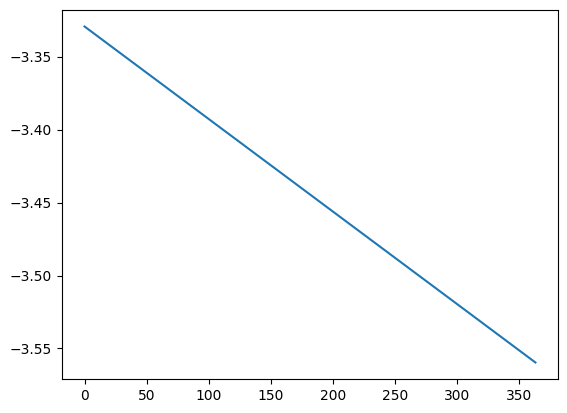

In [374]:
plt.plot(np.log10(rr_mode[1:365]))

In [364]:
for i in tqdm(range(364)):
    ax = gdf[i::365].plot(
        np.log10(rr_mode[i::365] * gdf.pop2021[i::365]),
        legend=1,
        norm=plt.Normalize(1.2, 2.6),
        cmap=cmo.deep,
    )
    ax.axis("off")
    ax.set_title(f"{np.unique(gdf.date)[i]}")
    fig = ax.get_figure()
    fig.savefig(f"./out/inlapred-{str(i).zfill(3)}.jpg", dpi=300)
    plt.close()

  0%|          | 0/364 [00:00<?, ?it/s]

In [365]:
!ffmpeg -framerate 30 -pattern_type glob -i 'out/inlapred*.jpg' -c:v libx264 -pix_fmt yuv420p out/inlapred.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

In [366]:
Video("./out/inlapred.mp4", width=500, height=600)

In [319]:
for i in tqdm(range(364)):
    ax = gdf[i::365].plot(
        (rr_mode[i::365] * gdf.pop2021[i::365] - gdf.cases[i::365]) / gdf.cases[i::365],
        legend=1,
        norm=plt.Normalize(-0.1, 0.1),
        vmin=-0.1,
        vmax=0.1,
        cmap="RdBu",
    )
    ax.axis("off")
    ax.set_title(f"{np.unique(gdf.date)[i]}")
    fig = ax.get_figure()
    fig.savefig(f"./out/inlares-{str(i).zfill(3)}.jpg", dpi=300)
    plt.close()

  0%|          | 0/364 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x284d08940>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/main/lib/python3.10/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/main/lib/python3.10/site-packages/tqdm/notebook.py", line 291, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


In [321]:
!ffmpeg -framerate 30 -pattern_type glob -i 'out/inlares*.jpg' -c:v libx264 -pix_fmt yuv420p out/inlares.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

In [322]:
Video("./out/inlares.mp4", width=500, height=600)